In [ ]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (7,5)
import seaborn as sns
colors = sns.color_palette("colorblind")

In [ ]:
# Define custom dash patterns for each line without names
custom_dashes = [
    (1, 0),           # Solid
    (1, 1),           # Dotted
    (4, 2),           # Dashed
    (3, 2, 1, 2),     # Dash-Dot
    (5, 2, 1, 2, 1, 2),  # Dash-Dot-Dot
    (8, 2),           # Long Dashes
    (2, 4),           # Loosely Dashed
    (5, 4, 1, 4),     # Sparse Dash-Dot
    (6, 4, 1, 4, 1, 4),  # Sparse Dash-Dot-Dot
    (1, 4),           # Loosely Dotted
    (4, 2, 1, 2, 1, 2),  # Dashed with Dots
    (2, 4, 1, 4, 2, 4)   # Custom Pattern 1
]

In [ ]:
def generate_random_symmetric_function(N):
    # Generate a random upper triangular matrix
    random_matrix = np.random.rand(N, N)

    # Make it symmetric
    symmetric_matrix = 0.5*(random_matrix + random_matrix.T)

    # Create a JAX array from the symmetric matrix
    B = jnp.array(symmetric_matrix)

    return B


def generate_random_vector(N):
    return jnp.array(np.random.rand(N))


def averager(Array_x, Array_y, num_iterations):
    DenVec = jnp.cumsum(jnp.array([1 for i in range(num_iterations+1)])).reshape((num_iterations+1,1))

    AvgArray_x = np.cumsum(Array_x,axis=0)/DenVec
    AvgArray_y = np.cumsum(Array_y,axis=0)/DenVec
    return (AvgArray_x, AvgArray_y)

In [ ]:
def lossBilinearBanal(x, y, loss_param):
    return jnp.dot(x, y)

def lossBilinear(x, y, loss_param):
    B = loss_param[0]
    return jnp.dot(jnp.dot(x, B), y)

def lossHighNonlinear_1(x, y, loss_param):
    return jnp.sum(x*(y-0.45) + phi_1(x) - phi_1(y))

def phi_1(z):
    return 0.25*jnp.power(z, 2) - 0.5*jnp.power(z, 4)  + (1/6)*jnp.power(z, 6)

def lossHighNonlinear_2(x, y, loss_param):
    epsilon = loss_param[0]
    return jnp.sum(x*y - epsilon*phi_2(y))

def phi_2(z):
    return 0.5*jnp.power(z, 2) - 0.25*jnp.power(z, 4)

def norm_iterates(x, y):
    return (jnp.linalg.norm(x,axis=1)**2 + jnp.linalg.norm(y,axis=1)**2)/2

def many_norm_iterates(x, y):
    norm_iteratess = np.zeros((np.shape(x)[0],np.shape(x)[1]))
    for i in range(0,np.shape(x)[0]):
      norm_iteratess[i,:] = (jnp.linalg.norm(x[i,:,:],axis=1)**2 + jnp.linalg.norm(y[i,:,:],axis=1)**2)/2

    return norm_iteratess

In [ ]:
def SEG(loss, loss_param, x_init, y_init, eta, rho, sigma, num_iterations, seed):
    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))


    x = x_init
    y = y_init

    d = x_init.shape[0]

    trajectory_x = [x]
    trajectory_y = [y]

    for k in range(num_iterations):

        np.random.seed((k+1)*seed)
        Z_x = sigma*jnp.array(np.random.normal(size=(d,)))
        Z_y = sigma*jnp.array(np.random.normal(size=(d,)))

        grad_x = grad_loss_x(x, y, loss_param) + Z_x
        grad_y = grad_loss_y(x, y, loss_param) + Z_y

        increment_x = grad_loss_x(x - rho*(grad_x), y + rho*(grad_y), loss_param) + Z_x
        increment_y = grad_loss_y(x - rho*(grad_x), y + rho*(grad_y), loss_param) + Z_y

        x = x - eta * increment_x
        y = y + eta * increment_y

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y



def SEG_Scheduler(loss, loss_param, x_init, y_init, eta, rho, sigma, num_iterations, p, seed):
    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))


    x = x_init
    y = y_init

    d = x_init.shape[0]

    trajectory_x = [x]
    trajectory_y = [y]

    for k in range(num_iterations):

        np.random.seed((k+1)*seed)
        Z_x = sigma*jnp.array(np.random.normal(size=(d,)))
        Z_y = sigma*jnp.array(np.random.normal(size=(d,)))

        grad_x = grad_loss_x(x, y, loss_param) + Z_x
        grad_y = grad_loss_y(x, y, loss_param) + Z_y

        increment_x = grad_loss_x(x - rho*(grad_x), y + rho*(grad_y), loss_param) + Z_x
        increment_y = grad_loss_y(x - rho*(grad_x), y + rho*(grad_y), loss_param) + Z_y


        x = x - (eta/np.power(eta*k+1,p)) * increment_x
        y = y + (eta/np.power(eta*k+1,p)) * increment_y

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y


def SHGD(loss, loss_param, x_init, y_init, eta, sigma, num_iterations, seed):

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt xx
    hessian_xx = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=0))

    # Define a function to compute the Hessian of loss(x, y) wrt xy
    hessian_xy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt yy
    hessian_yy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=1), argnums=1))

    x = x_init
    y = y_init
    trajectory_x = [x]
    trajectory_y = [y]

    d = x_init.shape[0]

    for k in range(num_iterations):

        np.random.seed((k+1)*seed)
        Z_x = sigma*jnp.array(np.random.normal(size=(d,)))
        Z_y = sigma*jnp.array(np.random.normal(size=(d,)))

        grad_x = grad_loss_x(x, y, loss_param) + Z_x
        grad_y = grad_loss_y(x, y, loss_param) + Z_y
        hess_xx = hessian_xx(x, y, loss_param)
        hess_yy = hessian_yy(x, y, loss_param)
        hess_xy = hessian_xy(x, y, loss_param)

        x = x - eta * (jnp.dot(hess_xx,grad_x) + jnp.dot(hess_xy,grad_y))
        y = y - eta * (jnp.dot(hess_xy,grad_x) + jnp.dot(hess_yy,grad_y))

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y



def SHGD_Scheduler(loss, loss_param, x_init, y_init, eta, sigma, num_iterations, p, seed):

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt xx
    hessian_xx = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=0))

    # Define a function to compute the Hessian of loss(x, y) wrt xy
    hessian_xy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt yy
    hessian_yy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=1), argnums=1))

    x = x_init
    y = y_init
    trajectory_x = [x]
    trajectory_y = [y]

    d = x_init.shape[0]

    for k in range(num_iterations):

        np.random.seed((k+1)*seed)
        Z_x = sigma*jnp.array(np.random.normal(size=(d,)))
        Z_y = sigma*jnp.array(np.random.normal(size=(d,)))

        grad_x = grad_loss_x(x, y, loss_param) + Z_x
        grad_y = grad_loss_y(x, y, loss_param) + Z_y
        hess_xx = hessian_xx(x, y, loss_param)
        hess_yy = hessian_yy(x, y, loss_param)
        hess_xy = hessian_xy(x, y, loss_param)

        x = x - (eta/np.power(eta*k+1,p)) * (jnp.dot(hess_xx,grad_x) + jnp.dot(hess_xy,grad_y))
        y = y - (eta/np.power(eta*k+1,p)) * (jnp.dot(hess_xy,grad_x) + jnp.dot(hess_yy,grad_y))

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y

In [ ]:
def SEGs(loss, loss_param, x_init, y_init, eta, rho, sigma, num_iterations, seeds):
  d = np.shape(x_init)[0]
  traj_x = np.zeros((len(seeds), num_iterations+1,d))
  traj_y = np.zeros((len(seeds), num_iterations+1,d))

  i=0
  for seed in seeds:
    print(seed)
    traj_x[i,:,:], traj_y[i,:,:]  = SEG(loss, loss_param, x_init, y_init, eta, rho, sigma, num_iterations, seed)
    i += 1

  return (traj_x, traj_y)


def SHGDs(loss, loss_param, x_init, y_init, eta, sigma, num_iterations, seeds):
  d = np.shape(x_init)[0]
  traj_x = np.zeros((len(seeds), num_iterations+1,d))
  traj_y = np.zeros((len(seeds), num_iterations+1,d))

  i=0
  for seed in seeds:
    print(seed)
    traj_x[i,:,:], traj_y[i,:,:]  = SHGD(loss, loss_param, x_init, y_init, eta, sigma, num_iterations, seed)
    i += 1

  return (traj_x, traj_y)


def SEG_Schedulers(loss, loss_param, x_init, y_init, eta, rho, sigma, num_iterations, p, seeds):
  d = np.shape(x_init)[0]
  traj_x = np.zeros((len(seeds), num_iterations+1,d))
  traj_y = np.zeros((len(seeds), num_iterations+1,d))

  i=0
  for seed in seeds:
    print(seed)
    traj_x[i,:,:], traj_y[i,:,:]  = SEG_Scheduler(loss, loss_param, x_init, y_init, eta, rho, sigma, num_iterations, p, seed)
    i += 1

  return (traj_x, traj_y)


def SHGD_Schedulers(loss, loss_param, x_init, y_init, eta, sigma, num_iterations,p, seeds):
  d = np.shape(x_init)[0]
  traj_x = np.zeros((len(seeds), num_iterations+1,d))
  traj_y = np.zeros((len(seeds), num_iterations+1,d))

  i=0
  for seed in seeds:
    print(seed)
    traj_x[i,:,:], traj_y[i,:,:]  = SHGD_Scheduler(loss, loss_param, x_init, y_init, eta, sigma, num_iterations, p, seed)
    i += 1

  return (traj_x, traj_y)

In [ ]:
import scipy.special as sc

def SHGD_TheorAvg_Iterate_NoG(loss_param, x_init, y_init, eta, sigma, num_iterations, alpha):
  ll = loss_param[0]
  t = np.arange(0,num_iterations+1)*eta
  b = (x_init**2 + y_init**2)/2
  k = 2*ll**2
  c = eta*sigma**2*ll**2

  if alpha == 0:
    return (b*np.exp(-k*t) + (c/k)*(1-np.exp(-k*t))).reshape((num_iterations+1,))

  if alpha == 1:
    return ( ( t+1 )**(-k-1) * (  b*(k-1)*(t+1) + c*( (t+1)**k - t-1 ) )/ (k-1) ).reshape((num_iterations+1,))

  if alpha == 0.5:
    return (np.exp(-2*k*np.sqrt(t+1)) * ( b*np.exp(2*k) + 2*c*(sc.expi(2*k*np.sqrt(t+1)) - sc.expi(2*k) ))).reshape((num_iterations+1,))



def SEG_TheorAvg_Iterate_NoG(loss_param, x_init, y_init, eta, rho, sigma, num_iterations, alpha):
  ll = loss_param[0]
  t = np.arange(0,num_iterations+1)*eta
  b = (x_init**2 + y_init**2)/2
  k = 2*rho*ll**2
  c = eta*sigma**2*(1 + rho**2*ll**2)

  if alpha == 0:
    return (b*np.exp(-k*t) + (c/k)*(1-np.exp(-k*t))).reshape((num_iterations+1,))

  if alpha == 1:
    return ( ( t+1 )**(-k-1) * (  b*(k-1)*(t+1) + c*( (t+1)**k - t-1 ) )/ (k-1) ).reshape((num_iterations+1,))

  if alpha == 0.5:
    return (np.exp(-2*k*np.sqrt(t+1)) * ( b*np.exp(2*k) + 2*c*(sc.expi(2*k*np.sqrt(t+1)) - sc.expi(2*k) ))).reshape((num_iterations+1,))

In [ ]:
"""
# Example:

x_init = jnp.array([0.5,0.5,0.5,0.5])
y_init = jnp.array([0.5,0.5,0.5,0.5])

B = jnp.array([[2.0, 0.0, 1.0, 0.0],
               [0.0, 3.0, 0.0, 1.0],
               [1.0, 0.0, 4.0, 0.0],
               [0.0, 1.0, 0.0, 5.0]])
"""

'\n# Example:\n\nx_init = jnp.array([0.5,0.5,0.5,0.5])\ny_init = jnp.array([0.5,0.5,0.5,0.5])\n\nB = jnp.array([[2.0, 0.0, 1.0, 0.0],\n               [0.0, 3.0, 0.0, 1.0],\n               [1.0, 0.0, 4.0, 0.0],\n               [0.0, 1.0, 0.0, 5.0]])\n'

In [ ]:
eta = 1e-2
#rho = np.sqrt(eta)

p1 = 0
p3 = 0.5
p5 = 1

rho = 5

num_iterations = 2000

sigma = 1e-3

scale = .1

x_init = jnp.array([1.0])*scale
y_init = jnp.array([1.0])*scale


B = jnp.array([[2.0]])

loss_param = [B]

loss = lossBilinear

In [ ]:
print(B)

# Calculate eigenvalues
eigenvalues = jax.numpy.linalg.eigvals(B)

print("Eigenvalues:", eigenvalues)

[[2.]]
Eigenvalues: [2.+0.j]


In [ ]:
loss_val = loss(x_init, y_init, loss_param)
grad_loss_x = jax.jit(jax.grad(loss, argnums=0))
grad_loss_y = jax.jit(jax.grad(loss, argnums=1))
normgrad_x = jnp.linalg.norm(grad_loss_x(x_init, y_init, loss_param))
normgrad_y = jnp.linalg.norm(grad_loss_y(x_init, y_init, loss_param))
print("Grad_x Norm ", normgrad_x)
print("Grad_y Norm ", normgrad_y)
print("Norm F ", jnp.sqrt(normgrad_x**2 + normgrad_y**2))
print("Loss:", loss_val)

Grad_x Norm  0.2
Grad_y Norm  0.2
Norm F  0.28284271247461906
Loss: 0.020000000000000004


In [ ]:
seeds = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

In [ ]:
EG1s_x, EG1s_y  = SEG_Schedulers(loss, loss_param, x_init, y_init, eta, rho, sigma, num_iterations, p1, seeds)
EG3s_x, EG3s_y  = SEG_Schedulers(loss, loss_param, x_init, y_init, eta, rho, sigma, num_iterations, p3, seeds)
EG5s_x, EG5s_y  = SEG_Schedulers(loss, loss_param, x_init, y_init, eta, rho, sigma, num_iterations, p5, seeds)

HGD1s_x, HGD1s_y =  SHGD_Schedulers(loss, loss_param, x_init, y_init, eta, sigma, num_iterations, p1, seeds)
HGD3s_x, HGD3s_y =  SHGD_Schedulers(loss, loss_param, x_init, y_init, eta, sigma, num_iterations, p3, seeds)
HGD5s_x, HGD5s_y =  SHGD_Schedulers(loss, loss_param, x_init, y_init, eta, sigma, num_iterations, p5, seeds)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [ ]:
EG1s_x= np.array(EG1s_x)
EG1s_y= np.array(EG1s_y)
EG3s_x= np.array(EG3s_x)
EG3s_y= np.array(EG3s_y)
EG5s_x= np.array(EG5s_x)
EG5s_y= np.array(EG5s_y)


HGD1s_x= np.array(HGD1s_x)
HGD1s_y= np.array(HGD1s_y)
HGD3s_x= np.array(HGD3s_x)
HGD3s_y= np.array(HGD3s_y)
HGD5s_x= np.array(HGD5s_x)
HGD5s_y= np.array(HGD5s_y)

In [ ]:
avg_EG1_x = np.mean(EG1s_x,axis=0)
avg_EG1_y = np.mean(EG1s_y,axis=0)


avg_EG3_x = np.mean(EG3s_x,axis=0)
avg_EG3_y = np.mean(EG3s_y,axis=0)


avg_EG5_x = np.mean(EG5s_x,axis=0)
avg_EG5_y = np.mean(EG5s_y,axis=0)

avg_HGD1_x = np.mean(HGD1s_x,axis=0)
avg_HGD1_y = np.mean(HGD1s_y,axis=0)

avg_HGD3_x = np.mean(HGD3s_x,axis=0)
avg_HGD3_y = np.mean(HGD3s_y,axis=0)

avg_HGD5_x = np.mean(HGD5s_x,axis=0)
avg_HGD5_y = np.mean(HGD5s_y,axis=0)

In [ ]:
ni_EG1 = many_norm_iterates(EG1s_x, EG1s_y)
ni_EG3 = many_norm_iterates(EG3s_x, EG3s_y)
ni_EG5 = many_norm_iterates(EG5s_x, EG5s_y)

ni_HGD1 = many_norm_iterates(HGD1s_x, HGD1s_y)
ni_HGD3 = many_norm_iterates(HGD3s_x, HGD3s_y)
ni_HGD5 = many_norm_iterates(HGD5s_x, HGD5s_y)


In [ ]:
avg_norm_iter_EG1 = np.mean(ni_EG1,axis=0)
std_norm_iter_EG1 = np.std(ni_EG1,axis=0)

avg_norm_iter_EG3 = np.mean(ni_EG3,axis=0)
std_norm_iter_EG3 = np.std(ni_EG3,axis=0)

avg_norm_iter_EG5 = np.mean(ni_EG5,axis=0)
std_norm_iter_EG5 = np.std(ni_EG5,axis=0)

avg_norm_iter_HGD1 = np.mean(ni_HGD1,axis=0)
std_norm_iter_HGD1 = np.std(ni_HGD1,axis=0)

avg_norm_iter_HGD3 = np.mean(ni_HGD3,axis=0)
std_norm_iter_HGD3 = np.std(ni_HGD3,axis=0)

avg_norm_iter_HGD5 = np.mean(ni_HGD5,axis=0)
std_norm_iter_HGD5 = np.std(ni_HGD5,axis=0)

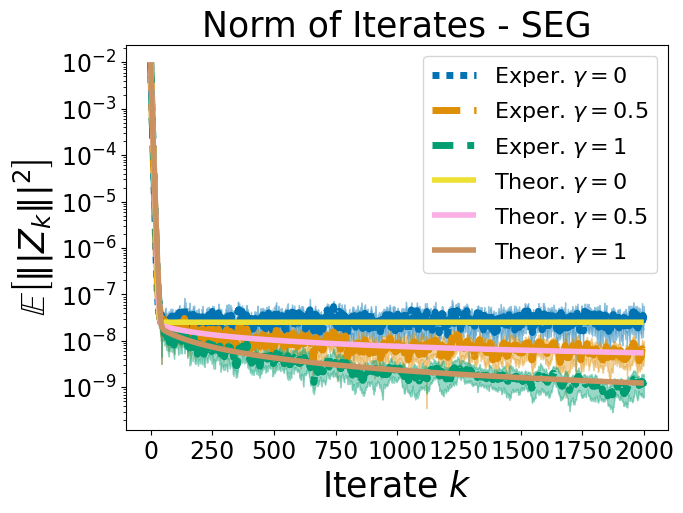

In [ ]:
plt.figure()
# We plot



line_1, = plt.plot(avg_norm_iter_EG1, color = colors[0],linewidth=5,linestyle='-', dashes=custom_dashes[1])
line_3, = plt.plot(avg_norm_iter_EG3, color = colors[1],linewidth=5,linestyle='-', dashes=custom_dashes[2])
line_5, = plt.plot(avg_norm_iter_EG5, color = colors[2],linewidth=5,linestyle='-', dashes=custom_dashes[3])

plt.fill_between( np.arange(0, num_iterations + 1),avg_norm_iter_EG1 - 0.5*std_norm_iter_EG1, avg_norm_iter_EG1 + 0.5*std_norm_iter_EG1,
                 color=colors[0], alpha=0.4)

plt.fill_between( np.arange(0, num_iterations + 1),avg_norm_iter_EG3 - 0.5*std_norm_iter_EG3, avg_norm_iter_EG3 + 0.5*std_norm_iter_EG3,
                 color=colors[1], alpha=0.4)

plt.fill_between( np.arange(0, num_iterations + 1),avg_norm_iter_EG5 - 0.5*std_norm_iter_EG5, avg_norm_iter_EG5 + 0.5*std_norm_iter_EG5,
                 color=colors[2], alpha=0.4)

line_7, = plt.plot(SEG_TheorAvg_Iterate_NoG(loss_param, x_init, y_init, eta, rho, sigma, num_iterations, 0), color = colors[8],linewidth=4,linestyle='-', dashes=custom_dashes[0])
line_8, = plt.plot(SEG_TheorAvg_Iterate_NoG(loss_param, x_init, y_init, eta, rho, sigma, num_iterations, 0.5), color = colors[6],linewidth=4,linestyle='-', dashes=custom_dashes[0])
line_9, = plt.plot(SEG_TheorAvg_Iterate_NoG(loss_param, x_init, y_init, eta, rho, sigma, num_iterations, 1), color = colors[5],linewidth=4,linestyle='-', dashes=custom_dashes[0])


plt.legend([line_1, line_3, line_5,line_7,line_8,line_9], [r'Exper. $\gamma = $' + str(p1), r'Exper. $\gamma = $' + str(p3), r'Exper. $\gamma = $' + str(p5), r'Theor. $\gamma = $' + str(p1), r'Theor. $\gamma = $' + str(p3), r'Theor. $\gamma = $' + str(p5), ],fontsize=16)
plt.title("Norm of Iterates - SEG",fontsize=25)
plt.xlabel(r'Iterate $k$',fontsize=25)
plt.ylabel(r'$\mathbb{E}\left[\||Z_k\||^2\right]$',fontsize=25)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.yscale('log')
plt.show()

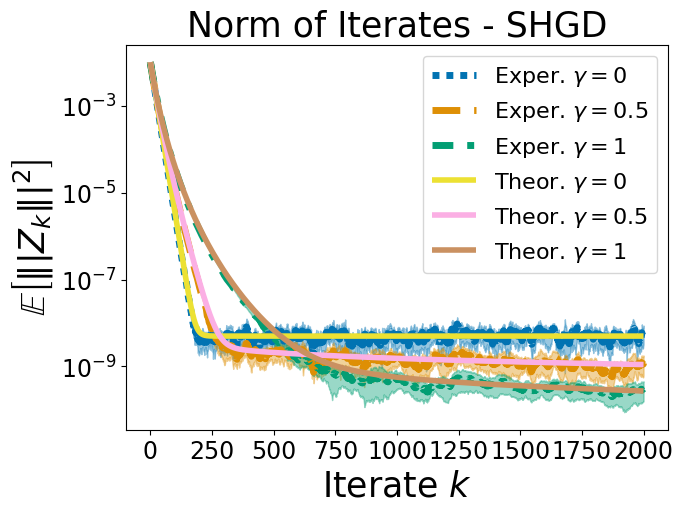

In [ ]:
plt.figure()
# We plot



line_1, = plt.plot(avg_norm_iter_HGD1, color = colors[0],linewidth=5,linestyle='-', dashes=custom_dashes[1])
line_3, = plt.plot(avg_norm_iter_HGD3, color = colors[1],linewidth=5,linestyle='-', dashes=custom_dashes[2])
line_5, = plt.plot(avg_norm_iter_HGD5, color = colors[2],linewidth=5,linestyle='-', dashes=custom_dashes[3])

plt.fill_between( np.arange(0, num_iterations + 1),avg_norm_iter_HGD1 - 0.5*std_norm_iter_HGD1, avg_norm_iter_HGD1 + 0.5*std_norm_iter_HGD1,
                 color=colors[0], alpha=0.4)

plt.fill_between( np.arange(0, num_iterations + 1),avg_norm_iter_HGD3 - 0.5*std_norm_iter_HGD3, avg_norm_iter_HGD3 + 0.5*std_norm_iter_HGD3,
                 color=colors[1], alpha=0.4)

plt.fill_between( np.arange(0, num_iterations + 1),avg_norm_iter_HGD5 - 0.5*std_norm_iter_HGD5, avg_norm_iter_HGD5 + 0.5*std_norm_iter_HGD5,
                 color=colors[2], alpha=0.4)

line_7, = plt.plot(SHGD_TheorAvg_Iterate_NoG(loss_param, x_init, y_init, eta, sigma, num_iterations, 0), color = colors[8],linewidth=4,linestyle='-', dashes=custom_dashes[0])
line_8, = plt.plot(SHGD_TheorAvg_Iterate_NoG(loss_param, x_init, y_init, eta, sigma, num_iterations, 0.5), color = colors[6],linewidth=4,linestyle='-', dashes=custom_dashes[0])
line_9, = plt.plot(SHGD_TheorAvg_Iterate_NoG(loss_param, x_init, y_init, eta, sigma, num_iterations, 1), color = colors[5],linewidth=4,linestyle='-', dashes=custom_dashes[0])


plt.legend([line_1, line_3, line_5,line_7,line_8,line_9], [r'Exper. $\gamma = $' + str(p1), r'Exper. $\gamma = $' + str(p3), r'Exper. $\gamma = $' + str(p5), r'Theor. $\gamma = $' + str(p1), r'Theor. $\gamma = $' + str(p3), r'Theor. $\gamma = $' + str(p5), ],fontsize=16)
plt.title("Norm of Iterates - SHGD",fontsize=25)
plt.xlabel(r'Iterate $k$',fontsize=25)
plt.ylabel(r'$\mathbb{E}\left[\||Z_k\||^2\right]$',fontsize=25)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.yscale('log')
plt.show()